# Machine Learning 2023-2024 - UMONS

# Bias-variance tradeoff.

**In this lab, we will experiment with the notorious 'Bias-Variance trade-off', a highly important concept in machine learning. In the context of a regression task, you've seen in the course that there exists an elegant decomposition of the MSE, which allows to illustrate this concept nicely. Contrary to previous labs in which we worked with real datasets, we will place ourself in a context where we know the true data generating process. This will enable us to estimate the bias and the variance of a given model.** 

**We import the necessary libraries.** 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(0)

### Data generating process

**1) Create the functions `fx` and `fy` that define the following data generating process:**

$$X \sim \mathcal{U}(-4, 4)$$

$$Y \sim f(X) + \epsilon$$

**where $\mathcal{U}(a, b)$ denotes a uniform distribution between $a$ and $b$, $f(X) = \text{sin}(X) + X / 3$, and $\epsilon \sim \mathcal{N}(0, 0.5^2)$ is a Gaussian noise with a normal distribution of mean 0 and standard deviation 0.5.**

**The parameter of `fx` should be:**
- **`size`, the size of the dataset which is sampled**

**The parameters of `fy` should be:**
- **`x`: an array of conditioning values corresponding to the random variable $X$**
- **`add_noise=True`: whether the noise $\epsilon$ should be added to $\text{sin}(X)$ (true by default).**

In [2]:
def fx(size):
    return np.random.uniform(-4, 4, size)

def fy(x, add_noise=True):
    y = np.sin(x) + x / 3
    if add_noise:
        y += np.random.normal(0, 0.5, len(x))
    return y

**We define the size of the training dataset to `n_train = 30`.**

**We also define a set of values `x_test` on which we will evaluate the bias-variance tradeoff.**

In [3]:
n_train = 30
x_test = np.linspace(-4, 4, 100)

**We plot a training dataset sampled using the data generating process. We also plot the function $f(x)$.**

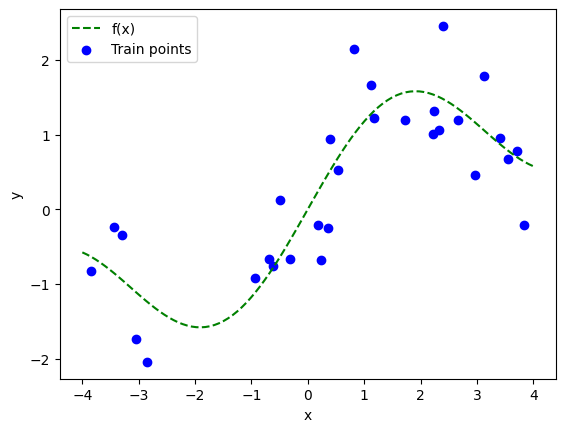

In [4]:
x_train = fx(n_train)
y_train = fy(x_train)
y_test = fy(x_test)
y_test_mean = fy(x_test, add_noise=False)

fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
ax.set(xlabel='x', ylabel='y')
ax.legend();

### Linear regression model

**2) Our goal is to predict the values of $Y$ given the conditioning values $x_\text{test}$.**
- **Fit a linear regression model on the training dataset.**
- **Predict `y_pred` on the test dataset `(x_test, y_test)` and report the mean squared error (MSE).**
**Note that scikit-learn expects inputs of shape `(n_train, n_features)`, where the second dimension is 1 in our case since $X$ is unidimensional.**

In [5]:
model = LinearRegression()
model.fit(x_train[:, np.newaxis], y_train)
y_pred = model.predict(x_test[:, np.newaxis])
y_test = fy(x_test)
mse = mean_squared_error(y_pred, y_test)
print(f'Test MSE: {mse:.3f}')

Test MSE: 0.720


**We draw the previous figure, with an added regression line corresponding to the predictions of the linear regression model on `x_test`. Does the model appear to be a good fit to the data? How do you link this observation to the bias-variance tradeoff?** 

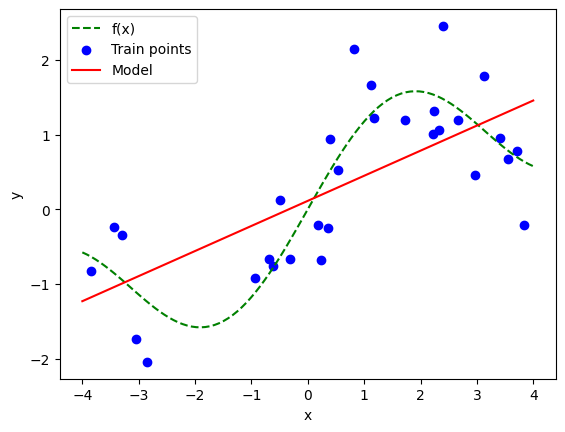

In [6]:
fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
ax.plot(x_test, y_pred, label='Model', color='red')
ax.set(xlabel='x', ylabel='y')
ax.legend();

Obviously, $f(x)$ can hardly be approached by a simple Linear Regression model. In this case, we expect the bias of our model to be high and its variance to be low.  

**3) We will now decompose our models' test MSE into a bias, variance and Bayes error term. Recall from the course that the MSE decomposition is given by:**

$$\mathbb{E}_{\mathcal{D},y,x}[(y-g(x))^2)] = \underbrace{\mathbb{E}_x[\text{Var}(y|x)]}_{\text{Bayes Error}} + \underbrace{\mathbb{E}_x[(f(x)-\mathbb{E}_\mathcal{D}[g(x)])^2]}_{\text{Bias}} + \underbrace{\mathbb{E}_x[\text{Var}(g(x))]}_{\text{Variance}}$$

**where $\mathcal{D}$ is a training set from the data generating process.**

**To estimate each term of the decomposition, we will:**
- **Fix a set of features $\{x_i^\text{test}\}_{i=1}^{n_\text{test}}$ on which we will evaluate the bias-variance tradeoff.**
- **For $j=1,\dots,J$, we will simulate the modeling pipeline:**
    - **Sample a dataset $\mathcal{D}_{j,\text{train}}$ containing $n_\text{train}$ observations $\{(x_{i,j}^\text{train}, y_{i,j}^\text{train})\}_{i=1}^{n_\text{train}}$.**
    - **Fit the model to $\mathcal{D}_{j,\text{train}}$, yielding $g_j$.**
    - **Sample a dataset $\mathcal{D}_{j,\text{test}}$ containing $n_\text{test}$ observations $\{(x_{i}^\text{test}, y_{i,j}^\text{test})\}_{i=1}^{n_\text{test}}$.**
    - **Make predictions on $\mathcal{D}_{j,\text{test}}$ using $g_j$.**

**The above steps will allow us to obtain an estimate of the Bias Variance of the fitted models:**
$$\mathbb{E}_{\mathcal{D},y,x}[(y-g(x))^2)] \simeq \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_\text{test}} \Big[\frac{1}{J} \sum_{j=1}^J (y^\text{test}_{i,j} - \bar{y_i})^2\Big]}_{\text{Bayes Error}} + \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_\text{test}} \Big[(f(x_i^\text{test}) - \bar{g}(x_i^\text{test}))^2\Big] }_{\text{Bias}} + \underbrace{\frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} \Big[\frac{1}{J}\sum_{j=1}^J(g_j(x_i^\text{test}) - \bar{g}(x_i^\text{test}))^2 \Big]}_{\text{Variance}},$$

**where $\bar{y}_i = \frac{1}{J} \sum_{j=1}^J y_{i,j}^\text{test}$ and $\bar{g}(x_i^\text{test}) = \frac{1}{J}\sum_{j=1}^J g_j(x_i^\text{test})$.**

**To this end, complete the functions `simulate_modeling_pipeline` and `bias_variance_estimator` below. The parameters are:**
- `model`: the scikit-learn model.
- `x_test`: the array of features $\{x_i^\text{test}\}_{i=1}^{n_\text{test}}$.
- `n_train`, `fx` and `fy`: they define the data generating process of $\mathcal{D}_{j,\text{test}} = \{(x_{i,j}^\text{train}, y_{i,j}^\text{train})\}_{i=1}^{n_\text{train}}$.
- `n_datasets`: the number of datasets $J$ to generate.

In [7]:
def simulate_modeling_pipeline(model, x_test, n_train, fx, fy):
    # The training dataset is generated using `fx` and `fy`
    x_train = fx(n_train) # TODO: x_train = ...
    y_train = fy(x_train) # TODO: y_train = ...
    # The test target is generated using `fy` and the provided `x_test`
    y_test = fy(x_test) # TODO: y_test = ...
    # The model is trained on the training dataset and used to predict the test target `y_pred`
    model.fit(x_train[:, np.newaxis], y_train) # TODO: fit the model
    y_pred = model.predict(x_test[:, np.newaxis]) # TODO: predict the test target
    return y_test, y_pred


def bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets):
    y_test, y_pred = [], []
    # We simulate the modeling pipeline on `n_datasets` datasets
    for _ in range(n_datasets):
        y_test_i, y_pred_i = simulate_modeling_pipeline(model, x_test, n_train, fx, fy)
        y_test.append(y_test_i)
        y_pred.append(y_pred_i)
    
    # We get targets and predictions as numpy arrays of shape (n_datasets, n_test)
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # We compute the MSE, bias, variance and Bayes error of each test point
    # Each of these quantities must be an array of shape (n_test,)
    # The suffix _x indicates that the estimation is conditional on x
    mse_x = np.mean((y_test - y_pred)**2, axis=0) # TODO: mse_x = ...
    bayes_error_x = np.var(y_test, axis=0, ddof=1) # TODO: bayes_error_x = ...
    bias_x = (np.mean(y_test, axis=0) - np.mean(y_pred, axis=0))**2 # TODO: bias_x = ...
    variance_x = np.var(y_pred, axis=0, ddof=1) # TODO: variance_x = ...
    return mse_x, bayes_error_x, bias_x, variance_x

**4) Call `bias_variance_estimator` and verify that the decomposition $\text{MSE} = \text{Bayes Error} + \text{Bias} + \text{Variance}$ is approximately correct when $J$ is sufficiently large. Does the value obtained for the Bayes Error make sense?**

In [8]:
mse_x, bayes_error_x, bias_x, variance_x = bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets=1000)
mse, bayes_error, bias, variance = mse_x.mean(), bayes_error_x.mean(), bias_x.mean(), variance_x.mean()
print(f'MSE = {mse:.5f} ~= {bayes_error + bias + variance:.5f} = {bayes_error:.5f} + {bias:.5f} + {variance:.5f} = Bayes Error + Bias + Variance')

MSE = 0.70802 ~= 0.70767 = 0.24809 + 0.40965 + 0.04993 = Bayes Error + Bias + Variance


As expected, we observe that the contribution of the bias term to the test MSE is high, while the contribution of the variance term is low. The Linear Regression model "underfits" our data, meaning it is not complex (flexible) enough to capture $f(x)$. The Bayes Error term is equal to 0.25, which corresponds to the variance of the random Gaussian noise $\epsilon$. This error term, also often called the irreducible error, represents the variability in our data. As its name suggests, it cannot be reduced, whatever the model chosen!   

**5) Based on the results of `bias_variance_estimator`, plot the MSE, Bayes error, bias and variance conditionally to $X$, for each $x$ in `x_test`. How do you interpret the plot?**

Maximum estimation error for the decomposition: 0.020154911879769144


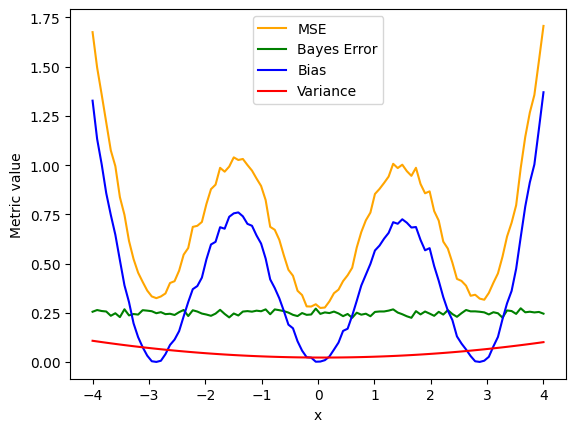

In [9]:
def plot_decomposition_per_x(model):
    mse_x, bayes_error_x, bias_x, variance_x = bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets=1000)
    # As an optional check, we can verify that the decomposition is correct conditionally to each x
    total_decomposition_x = bias_x + variance_x + bayes_error_x
    print('Maximum estimation error for the decomposition:', np.max(np.abs(mse_x - total_decomposition_x)))
    
    fig, ax = plt.subplots()
    ax.plot(x_test, mse_x, label='MSE', color='orange')
    ax.plot(x_test, bayes_error_x, label='Bayes Error', color='green')
    ax.plot(x_test, bias_x, label='Bias', color='blue')
    ax.plot(x_test, variance_x, label='Variance', color='red')
    ax.set(xlabel='x', ylabel='Metric value')
    ax.legend()

plot_decomposition_per_x(LinearRegression())

Due to its lack of flexibility, the linear regression model will tend to make similar predictions given different datasets. In this case, as observed in the plot of the predictions of the linear regression model, the predictions tend to be the farthest away from $f(x)$ near -1.5 and 1.5. This explains why the bias is the highest at these points. Since the predictions are nearly constant, the variance is close to 0. The Bayes error rate is constant across $x$ because the noise is the same conditional to any $x$.

### Polynomial regression model

**We will now study how the bias and variance of a model evolve when varying its complexity. To this end, we will use polynomial regression models with varying degrees. Examples of predictions are given below.**

In [10]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

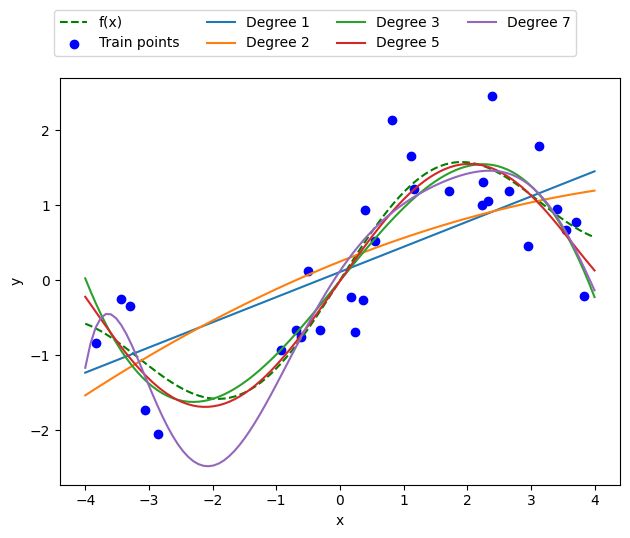

In [11]:
# We fit models of varying degrees on the training dataset
models = []
degrees = [1, 2, 3, 5, 7]
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    model.fit(x_train[:, np.newaxis], y_train)
    models.append(model)
# We plot the predictions of the models
fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')
for model in models:
    degree = model.get_params()['polynomialfeatures__degree']
    y_pred = model.predict(x_test[:, np.newaxis])
    ax.plot(x_test, y_pred, label=f'Degree {degree}')
ax.set(xlabel='x', ylabel='y')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncol=4)
fig.tight_layout()

**6) For polynomial regression models with degrees ranging from 1 to 6, can you collect the MSE, Bayes error, bias, and variance, and plot them as function of the degree? What do you observe?**

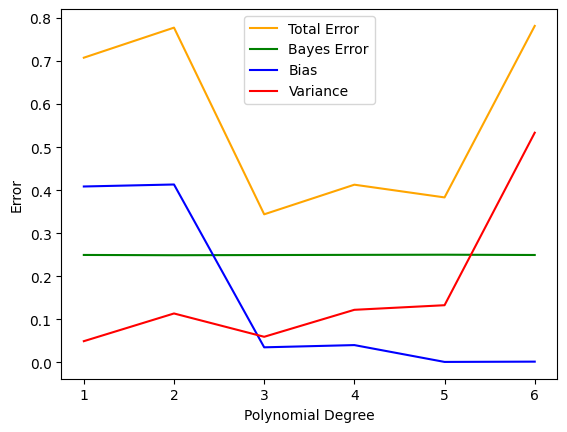

In [12]:
degrees = np.arange(1, 7)

mse_list, bayes_error_list, bias_list, variance_list = [], [], [], []
for degree in degrees:
    model = PolynomialRegression(degree, fit_intercept=True)
    mse_x, bayes_error_x, bias_x, variance_x = bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets=1000)
    mse_list.append(mse_x.mean())
    bayes_error_list.append(bayes_error_x.mean())
    bias_list.append(bias_x.mean())
    variance_list.append(variance_x.mean())

fig, ax = plt.subplots()
ax.plot(degrees, mse_list, label='Total Error', color='orange')
ax.plot(degrees, bayes_error_list, label='Bayes Error', color='green')
ax.plot(degrees, bias_list, label='Bias', color='blue')
ax.plot(degrees, variance_list, label='Variance', color='red')
ax.set(xlabel='Polynomial Degree', ylabel='Error')
ax.legend();

As the polynomial degree increases, the bias term tends to decrease until it reaches a relatively constant value. On the other hand, the variance term tends to increase with the polynomial degree. 

This observation can be directly linked to the bias-variance tradeoff. Indeed, by increasing the polynomial degree, we increase the complexity (flexibility) of our model. On the one hand, this has the effect of decreasing the bias (i.e. the average predictions over all training datasets tend to be more accurate), but at the same time, we increase the variance (i.e. the variance of the predictions across datasets increases).

The Bayes Error term remains constant, as expected.

In this case, the best polynomial regression models have a degree between 3 and 5 because they achieve a good tradeoff between bias and variance.

### $K$-nearest neighbors regression model

**Finally, we investigate another class of models, $K$-nearest neighbors regression models.**

**Given a feature $x$, these models select the $K$ points $\{(x_k, y_k)\}_{k=1}^K$ whose feature are closest to $x$ and predict the average target among these $K$ points. Examples of predictions are given below.**

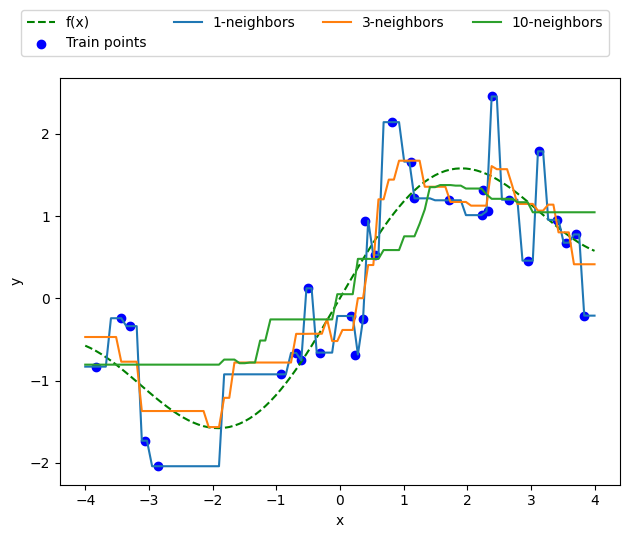

In [13]:
models = []
n_neighbors_list = [1, 3, 10]
for n_neighbors_list in n_neighbors_list:
    model = KNeighborsRegressor(n_neighbors=n_neighbors_list)
    model.fit(x_train[:, np.newaxis], y_train)
    models.append(model)

fig, ax = plt.subplots()
ax.plot(x_test, y_test_mean, label='f(x)', color='green', ls='--')
ax.scatter(x_train, y_train, label='Train points', color='blue')

for model in models:
    K = model.get_params()['n_neighbors']
    y_pred = model.predict(x_test[:, np.newaxis])
    ax.plot(x_test, y_pred, label=f'{K}-neighbors')

ax.set(xlabel='x', ylabel='y')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncol=4)
fig.tight_layout()

**7) Repeat the same exercise as in 6), but for the number of neighbors in a `KNeighborsRegressor`.**

**Are the evolution of the bias, variance and Bayes error term expected ?**

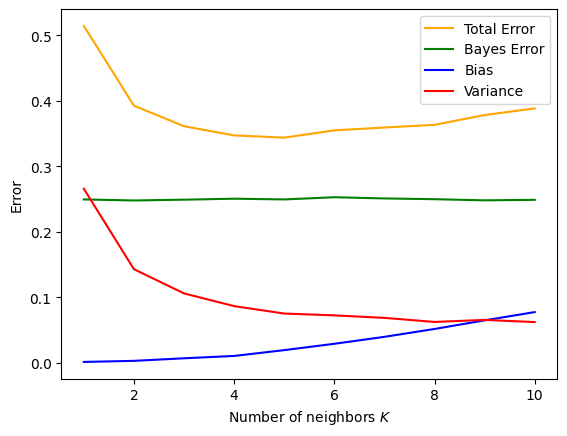

In [14]:
n_neighbors_list = np.arange(1, 11)

mse_list, bayes_error_list, bias_list, variance_list = [], [], [], []
for n_neighbors in n_neighbors_list:
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    mse_x, bayes_error_x, bias_x, variance_x = bias_variance_estimator(model, x_test, n_train, fx, fy, n_datasets=1000)
    mse_list.append(mse_x.mean())
    bayes_error_list.append(bayes_error_x.mean())
    bias_list.append(bias_x.mean())
    variance_list.append(variance_x.mean())

fig, ax = plt.subplots()
ax.plot(n_neighbors_list, mse_list, label='Total Error', color='orange')
ax.plot(n_neighbors_list, bayes_error_list, label='Bayes Error', color='green')
ax.plot(n_neighbors_list, bias_list, label='Bias', color='blue')
ax.plot(n_neighbors_list, variance_list, label='Variance', color='red')
ax.set(xlabel='Number of neighbors $K$', ylabel='Error')
ax.legend();

For the KNN Regressor, the opposite behaviour is observed, i.e. the bias increases with the number of neighbors, while the variance decreases. For KNN, we may be tempted to think that considering additional neighbors to make a prediction contributes to increasing the model's complexity. However, this is the opposite. Consider the case where all instances in the training set are used to make a prediction. In this case, all predictions will be equal whatever the input $x$, which corresponds to a constant model. In practice, increasing the number of neighbors in a KNN model tends to smooth its predictions, and hence to increase its bias. Alternatively, a KNN model which makes its predictions based on a single neighbor in the training set is more susceptible to show high variability for different training sets, which translates to an increased variance.

In this case, the best models have a number of neighbors around 5 because they achieve a good tradeoff between bias and variance.

### Optional experiments

**Based on the code above, can you answer the following questions?**
- **How does the bias-variance tradeoff change when varying the number of training samples?**
- **How does the bias-variance tradeoff change with a more complex data generating process?**
- **Can you plot the MSE, Bayes error, bias and variance in function of $x$ for different polynomials and $K$-nearest neighbors regression models? How do you interpret them?**